Original link to Colab Project: https://colab.research.google.com/drive/1dmDsxJLqMZObZ8kJfe-kvjxuB-U-NfvB

In [0]:
# download the data repository
!git clone https://github.com/FakeNewsChallenge/fnc-1.git

Cloning into 'fnc-1'...
remote: Enumerating objects: 49, done.
remote: Total 49 (delta 0), reused 0 (delta 0), pack-reused 49
Unpacking objects: 100% (49/49), done.


In [0]:
!pip install keras==2.1.6

In [0]:
# some basic imports
import pandas as pd
import nltk
import sklearn
import numpy as np
from keras.models import load_model
import pickle

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path = 'drive/My Drive/'

# Function to Get Training and Testing Data

In [0]:
def read_data(dataset):
  if dataset == 'train':
    prefix = 'train'
  elif dataset == 'test':
    prefix = 'competition_test'
  else:
    raise ValueError('Dataset can be either train or test')

  # get data
  df_bodies = pd.read_csv(f'fnc-1/{prefix}_bodies.csv')
  df_headlines = pd.read_csv(f'fnc-1/{prefix}_stances.csv')

  # merge the two datasets on the 'Body ID' attribute
  df = pd.merge(df_headlines, df_bodies, on='Body ID')
  del df_bodies, df_headlines

  return df

# Training for *related-unrelated*

### Read the data

In [0]:
# read the data
df_train = read_data('train')
df_test = read_data('test')
df_train.head()

,Headline,Body ID,Stance,articleBody
0,Police find mass graves with at least '15 bodi...,712,unrelated,Danny Boyle is directing the untitled film\n\n...
1,Seth Rogen to Play Apple’s Steve Wozniak,712,discuss,Danny Boyle is directing the untitled film\n\n...
2,Mexico police find mass grave near site 43 stu...,712,unrelated,Danny Boyle is directing the untitled film\n\n...
3,Mexico Says Missing Students Not Found In Firs...,712,unrelated,Danny Boyle is directing the untitled film\n\n...
4,New iOS 8 bug can delete all of your iCloud do...,712,unrelated,Danny Boyle is directing the untitled film\n\n...


### Generate TF-IDF representations of documents

In [0]:
# compute tf-idf after removing stopwords for Related-Unrelated Classification
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# list of text documents
text = np.append(df_train.articleBody.unique(), df_train.Headline.unique())

max_features = 1000

# create the transform
vectorizer_ru = TfidfVectorizer(max_features=max_features, stop_words='english')
# vectorizer = CountVectorizer(max_features=max_features, stop_words='english')
# tokenize and build vocab
vectorizer_ru.fit(text)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=1000,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [0]:
# store vectorizer
pickle.dump(vectorizer_ru, open(path + "vectorizer_ru.pickle", "wb"))

### Extract the features we want to train on
For example: cosine similarity, Euclidean distance, ...

In [0]:
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from scipy.spatial.distance import dice

def feature_extraction(df):
  # store tfidf values of the headlines and the articleBody in df itself
  df['headline_tfidf'] = vectorizer_ru.transform(df.Headline).toarray().tolist()
  df['articleBody_tfidf'] = vectorizer_ru.transform(df.articleBody).toarray().tolist()
  # df['combined_tfidf'] = np.concatenate((df['headline_tfidf'].tolist(), df['articleBody_tfidf'].tolist()), axis=1).tolist()
  
  del df['Headline'], df['articleBody']

  # compute euclidean distance
  df['euclidean'] = np.diagonal(euclidean_distances(df['headline_tfidf'].tolist(), df['articleBody_tfidf'].tolist()))
  # compute cosine similarity
  df['cosine'] = np.diagonal(cosine_similarity(df['headline_tfidf'].tolist(), df['articleBody_tfidf'].tolist()))
  # compute dice similarity
  df['dice'] = np.vectorize(dice)(df['headline_tfidf'], df['articleBody_tfidf'])
  
  # change string class to 0 or 1
  df['Stance'] = df['Stance'].map({'agree': 1, 'disagree': 1, 'discuss': 1, 'unrelated': 0})

  del df['headline_tfidf'], df['articleBody_tfidf']
  return df

In [0]:
df_train = feature_extraction(df_train)
df_test = feature_extraction(df_test)
df_train.head()

### Define the model and train it

In [0]:
# Compute class-weights:
#   Since the class examples in the training data are imbalanced, we assign a weight to the loss function
#   to learn update the weights while learning.
#   https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras

from sklearn.utils import class_weight

class_wise_counts = df_train.groupby(by='Stance').count()['Body ID']
print(class_wise_counts)

class_weights = class_weight.compute_class_weight('balanced', np.unique(df_train['Stance']), df_train['Stance'])
class_weight_dict = dict(enumerate(class_weights))
print("Weighting in the loss function:", class_weight_dict)

Stance
0    36545
1    13427
Name: Body ID, dtype: int64
Weighting in the loss function: {0: 0.6837050212067314, 1: 1.860877336709615}


In [0]:
from keras.utils import to_categorical

# prepare training and testing data
# X_train = np.array(df_train['combined_tfidf'].tolist())
X_train = df_train[['cosine', 'euclidean', 'dice']].to_numpy()
y_train = to_categorical(df_train['Stance'], num_classes=2)

# X_test = np.array(df_test['combined_tfidf'].tolist())
X_test = df_test[['cosine', 'euclidean', 'dice']].to_numpy()
y_test = to_categorical(df_test['Stance'], num_classes=2)

In [0]:
from keras.models import Sequential
from keras.layers import Dense

# define the neural network model
model_ru = Sequential()
model_ru.add(Dense(10, input_dim=3, activation='relu'))
model_ru.add(Dense(2, activation='sigmoid'))
model_ru.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=['accuracy'])

print('Model compiled.')

Model compiled.


In [0]:
# train the neural network model
history = model_ru.fit(X_train, y_train, epochs=20, batch_size=50, validation_data=(X_test, y_test), class_weight=class_weight_dict)




Train on 49972 samples, validate on 25413 samples
Epoch 1/20





49972/49972 [==============================] - 7s 137us/step - loss: 0.5758 - acc: 0.8600 - val_loss: 0.5014 - val_acc: 0.8435
Epoch 2/20
49972/49972 [==============================] - 3s 56us/step - loss: 0.4409 - acc: 0.9403 - val_loss: 0.4364 - val_acc: 0.8647
Epoch 3/20
49972/49972 [==============================] - 3s 56us/step - loss: 0.3536 - acc: 0.9519 - val_loss: 0.3932 - val_acc: 0.8696
Epoch 4/20
49972/49972 [==============================] - 3s 56us/step - loss: 0.2997 - acc: 0.9560 - val_loss: 0.3684 - val_acc: 0.8735
Epoch 5/20
49972/49972 [==============================] - 3s 56us/step - loss: 0.2653 - acc: 0.9583 - val_loss: 0.3515 - val_acc: 0.8750
Epoch 6/20
49972/49972 [==============================] - 3s 56us/step - loss: 0.2421 - acc: 0.9595 - val_loss: 0.3399 - val_acc: 0.8756
Epoch 7/20
49972/49972 [==============================] - 3s 55us/step - loss: 0.2255 - acc: 0.9606 - val_loss: 0.3328 

In [0]:
# store model
model_ru.save(path + 'model_ru.h5')

### Print confusion matrix

Stance
0    18349
1     7064
Name: Body ID, dtype: int64


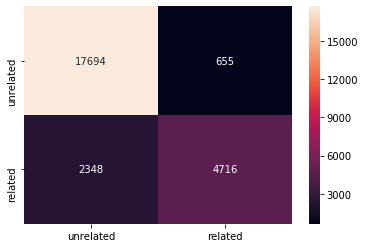

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

print(df_test.groupby(by='Stance').count()['Body ID'])

y_pred = model_ru.predict(X_test)
class_names = ['unrelated', 'related']
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

In [0]:
del model_ru

### Prepare Demo

In [0]:
# load model again
model_ru = load_model(path + 'model_ru.h5')
# load vectorizer
vectorizer_ru = pickle.load(open(path + "vectorizer_ru.pickle", 'rb'))

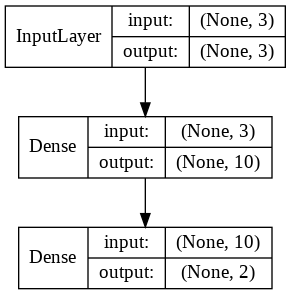

In [0]:
from keras.utils import plot_model
from IPython.display import display
from PIL import Image

plot_model(model_ru, to_file='model_ru.png', show_shapes=True, show_layer_names=False)
display(Image.open("model_ru.png"))

In [0]:
model_ru.summary()

In [0]:
# prepare data for demo
apple_headline = "The lowest-ever Apple Watch 3 price is back... but there's a catch"
pales_headline = "Social media solidarity for wounded Palestinian journalist"

apple_body = "The best-ever Apple Watch 3 deal is back in stock - although you're not going to get it easily. The white, 38mm version of one of our best wearables is down to $129 - a simply amazing price for what you're getting - but you'll need to seek it out in a local store.\n\nThat's right: while we're hearing a few reports that you can still snag it online if you're lucky, the Apple Watch 3 is only going to be this low price if you're willing to walk to a local store.\n\nWe'd also add the caveat that the Walmart prices are fluctating wildly throughout the day on a number of deals, so you might find this Apple Watch 3 deal fluctuating throughout the day."
pales_body = "Thousands of social media users have taken part in a campaign to support Palestinian freelance journalist Muath Amarneh, who lost his eye after being wounded while covering a protest in the occupied West Bank last week.\n\nJournalists from across the Arab world launched the campaign of solidarity after Amarneh was hit in the eye, apparently with a rubber bullet fired by Israeli forces who had arrived to quell the demonstrations last Friday in Surif."

df = pd.DataFrame({'Headline': [apple_headline, pales_headline, apple_headline, pales_headline], 'articleBody': [apple_body, pales_body, pales_body, apple_body], 'Stance': ['agree', 'agree', 'unrelated', 'unrelated']})
print(df)
df = feature_extraction(df)

                                            Headline  ...     Stance
0  The lowest-ever Apple Watch 3 price is back......  ...      agree
1  Social media solidarity for wounded Palestinia...  ...      agree
2  The lowest-ever Apple Watch 3 price is back......  ...  unrelated
3  Social media solidarity for wounded Palestinia...  ...  unrelated

[4 rows x 3 columns]


In [0]:
X = df[['cosine', 'euclidean', 'dice']].to_numpy()
y_pred = model_ru.predict(X)
print(y_pred)
print(np.argmax(y_pred, axis=1))

[[0.00814047 0.9843762 ]
 [0.03804943 0.93911594]
 [0.9376588  0.07622379]
 [0.9376588  0.07622379]]
[1 1 0 0]


# Training for *agrees-disagrees-discusses*

### Read the data

In [0]:
# read the data
df_train = read_data('train')
df_test = read_data('test')
# df_train = df_train[df_train.Stance == 'agree'].head(5)

### Generate TF-IDF representations of documents

In [0]:
# compute tf-idf after removing stopwords for Related-Unrelated Classification
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# list of text documents
text = np.append(df_train.articleBody.unique(), df_train.Headline.unique())

max_features = 5000

# create the transform
vectorizer_add = TfidfVectorizer(max_features=max_features, use_idf=False, ngram_range=(1,4), stop_words='english')
# vectorizer = CountVectorizer(max_features=max_features, ngram_range=(1,4), stop_words='english')
# tokenize and build vocab
vectorizer_add.fit(text)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=5000,
                min_df=1, ngram_range=(1, 4), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=False, vocabulary=None)

In [0]:
# store vectorizer
pickle.dump(vectorizer_add, open(path + "vectorizer_add.pickle", "wb"))

### Extract the features we want to train on
For example: cosine similarity, Euclidean distance, ...

In [0]:
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity

def feature_extraction(df):
  # remove instances when the stance is unrelated
  df = df.drop(df[df.Stance == 'unrelated'].index)

  # store tfidf values of the headlines and the articleBody in df itself
  df['headline_tfidf'] = vectorizer_add.transform(df.Headline).toarray().tolist()
  df['articleBody_tfidf'] = vectorizer_add.transform(df.articleBody).toarray().tolist()
  df['combined_tfidf'] = np.concatenate((df['headline_tfidf'].tolist(), df['articleBody_tfidf'].tolist()), axis=1).tolist()
  
  # compute euclidean distance
  # df['euclidean'] = np.diagonal(euclidean_distances(df['headline_tfidf'].tolist(), df['articleBody_tfidf'].tolist()))
  # df['cosine'] = np.diagonal(cosine_similarity(df['headline_tfidf'].tolist(), df['articleBody_tfidf'].tolist()))

  # change string class to 0 or 1
  df['Stance'] = df['Stance'].map({'agree':1, 'disagree': 2, 'discuss': 0})

  del df['Headline'], df['articleBody'], df['headline_tfidf'], df['articleBody_tfidf']
  return df

In [0]:
df_train = feature_extraction(df_train)
df_test = feature_extraction(df_test)

print("Training data:", len(df_train))
print("Testing data:", len(df_test))

df_train.head()

Training data: 13427
Testing data: 7064


,Body ID,Stance,combined_tfidf
1,712,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,712,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,712,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
15,712,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
20,712,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [0]:
df_train.groupby(by='Stance').count()

,Body ID,combined_tfidf
Stance,,
0,8909,8909
1,3678,3678
2,840,840


### Balance data by adding random noise to the classes that are less in number

In [0]:
def balance_data(df, stance, num_of_times):
  '''
    Take all samples of stance, add random noise to it, add to original list of samples.
  '''

  df_new = df[df.Stance == stance]
  df_to_augment = pd.DataFrame().append([df_new]*(num_of_times - 1), ignore_index=True)

  for idx, row in df_to_augment.iterrows():
    combined = np.array(row['combined_tfidf'])
    nonzero_idxs = combined.nonzero()[0]
    # rands = np.random.normal(0, 1, len(nonzero_idxs))
    rands = np.random.randint(-2, 3, len(nonzero_idxs))
    combined[nonzero_idxs] += rands
    combined = np.abs(combined) # take absolute value to remove negative values
    row['combined_tfidf'] = combined.tolist()
  
  df = pd.concat([df, df_to_augment])
  return df

In [0]:
df_train = balance_data(df_train, 1, num_of_times=2)
df_train = balance_data(df_train, 2, num_of_times=10)
df_train.groupby(by='Stance').count()

,Body ID,combined_tfidf
Stance,,
0,8909,8909
1,7356,7356
2,8400,8400


### Define the model and train it

In [0]:
# Compute class-weights:
#   Since the class examples in the training data are imbalanced, we assign a weight to the loss function
#   to learn update the weights while learning.
#   https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras

from sklearn.utils import class_weight

class_wise_counts = df_train.groupby(by='Stance').count()['Body ID']
print(class_wise_counts)

class_weights = class_weight.compute_class_weight('balanced', np.unique(df_train['Stance']), df_train['Stance'])
class_weight_dict = dict(enumerate(class_weights))
print("Weighting in the loss function:", class_weight_dict)
class_weight_dict[1] = 2 * class_weight_dict[1]
class_weight_dict[2] = 10 * class_weight_dict[2]
print("Weighting in the loss function:", class_weight_dict)

Stance
0    8909
1    3678
2     840
Name: Body ID, dtype: int64
Weighting in the loss function: {0: 0.5023758745837542, 1: 1.2168751132862063, 2: 5.328174603174603}
Weighting in the loss function: {0: 0.5023758745837542, 1: 2.4337502265724127, 2: 53.28174603174603}


In [0]:
# prepare training and testing data
from keras.utils import to_categorical

# shuffle training data
df_train = df_train.sample(frac=1)

# # remove all but one discuss rows ("staged learning")
# df_train_agree_disagree = df_train[df_train.Stance != 2]
# df_train_agree_disagree = pd.concat([df_train_agree_disagree, df_train[df_train.Stance == 2].head(1)])

X_train = np.array(df_train['combined_tfidf'].tolist())
# X_train = df_train[['cosine', 'euclidean']].to_numpy()
y_train = to_categorical(df_train['Stance'], num_classes=3)
# y_train = df_train['Stance']

X_test = np.array(df_test['combined_tfidf'].tolist())
# X_test = df_test[['cosine', 'euclidean']].to_numpy()
y_test = to_categorical(df_test['Stance'], num_classes=3)
# y_test = df_test['Stance']

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

# _add = _AgreeDisagreeDiscuss 
# define the neural network model
model_add = Sequential()
model_add.add(Dense(128, input_dim=10000, activation='relu'))
model_add.add(Dense(32, activation='relu'))
model_add.add(Dropout(0.4))
model_add.add(Dense(16, activation='relu'))
model_add.add(Dense(3, activation='sigmoid'))
model_add.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print('Model compiled.')

Model compiled.


In [0]:
# train the neural network model
history = model_add.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test), class_weight=class_weight_dict)

Train on 13427 samples, validate on 7064 samples
Epoch 1/15
13427/13427 [==============================] - 3s 236us/step - loss: 0.3364 - acc: 0.8525 - val_loss: 0.5020 - val_acc: 0.7839
Epoch 2/15
13427/13427 [==============================] - 3s 194us/step - loss: 0.1566 - acc: 0.9335 - val_loss: 0.7070 - val_acc: 0.7780
Epoch 3/15
13427/13427 [==============================] - 3s 195us/step - loss: 0.0982 - acc: 0.9606 - val_loss: 0.8847 - val_acc: 0.7780
Epoch 4/15
13427/13427 [==============================] - 3s 200us/step - loss: 0.0749 - acc: 0.9710 - val_loss: 1.0345 - val_acc: 0.7687
Epoch 5/15
13427/13427 [==============================] - 3s 199us/step - loss: 0.0539 - acc: 0.9800 - val_loss: 1.1147 - val_acc: 0.7652
Epoch 6/15
13427/13427 [==============================] - 3s 196us/step - loss: 0.0425 - acc: 0.9840 - val_loss: 1.2090 - val_acc: 0.7735
Epoch 7/15
13427/13427 [==============================] - 3s 195us/step - loss: 0.0318 - acc: 0.9886 - val_loss: 1.4054 - v

In [0]:
# store model
# model_add.save(path + 'model_add.h5')

### Print confusion matrix

Stance
0    4464
1    1903
2     697
Name: Body ID, dtype: int64
[[3359  928  177]
 [ 715 1085  103]
 [ 259  346   92]]
0.6421291053227633


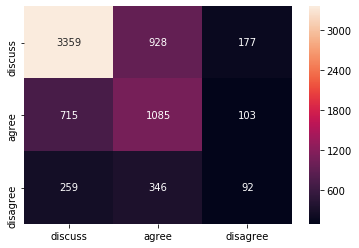

In [0]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

print(df_test.groupby(by='Stance').count()['Body ID'])

y_pred = model_add.predict(X_test)
class_names = ['discuss', 'agree', 'disagree']
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
print(cm)
print(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

# row is true value
# column is predicted value

In [0]:
# del model_add

### Prepare Demo

In [0]:
# load model again
model_add = load_model(path + 'model_add.h5')
# load vectorizer
vectorizer_add = pickle.load(open(path + "vectorizer_add.pickle", 'rb'))


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


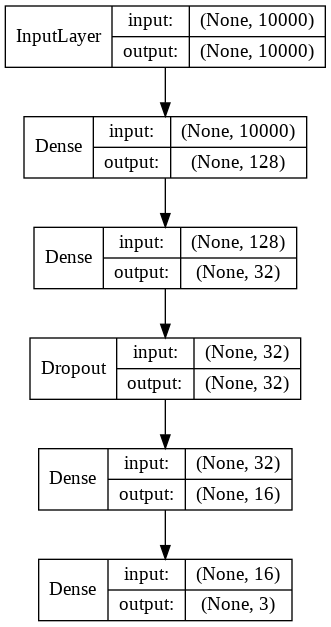

In [0]:
from keras.utils import plot_model
from IPython.display import display
from PIL import Image

plot_model(model_add, to_file='model_add.png', show_shapes=True, show_layer_names=False)
display(Image.open("model_add.png"))

In [0]:
# prepare data for demo
apple_headline = "Truly innova­tive products leave their mark on the world instead of the planet."
pales_headline = "Social media solidarity for wounded Palestinian journalist"
sports_headline = "Messi is a left legged human being and is extemely tall and muscular. He is the best footballer on the planet"

apple_body = 'Just as much innovation goes into the materials your Apple products are made of — and how they’re made — as into what they do. You can see that in the new MacBook Air and Mac mini. Their enclosures are made from 100% recycled aluminium, without compromising strength or finish. In so many ways, the most advanced products are the ones that make the least environmental impact.'
# apple_body = "Not only is Apple the best company, it even treats its employees well. Everyone loves Apple and they should for Apple is doing everything the best anyone can. Apple has the best services and is followed by everyone because it is the best"
pales_body = "Thousands of social media users have taken part in a campaign to support Palestinian freelance journalist Muath Amarneh, who lost his eye after being wounded while covering a protest in the occupied West Bank last week.\n\nJournalists from across the Arab world launched the campaign of solidarity after Amarneh was hit in the eye, apparently with a rubber bullet fired by Israeli forces who had arrived to quell the demonstrations last Friday in Surif."
sports_body = "Messi is a short footballer. He is such a mediocre player that he may make his team lose singlehandedly. One should not ideally buy him for his worth. He should be valued far less and then he might be worth it. Since Barca got him for free, he is technically worth his worth."
# sports_body = "Messi is limping right legged footballer who is short as a midget and such a weak player that he is literally called the weakling. No wonder he is the worst footballer."

df = pd.DataFrame({'Headline': [apple_headline, pales_headline, sports_headline], 'articleBody': [apple_body, pales_body, sports_body], 'Stance': ['agree', 'discuss', 'disagree']})
print(df)
df = feature_extraction(df)

                                            Headline  ...    Stance
0  Truly innova­tive products leave their mark on...  ...     agree
1  Social media solidarity for wounded Palestinia...  ...   discuss
2  Messi is a left legged human being and is exte...  ...  disagree

[3 rows x 3 columns]


In [0]:
X = np.array(df['combined_tfidf'].tolist())
y_pred = model_add.predict(X)
print(y_pred)
print(np.argmax(y_pred, axis=1))
# {'discuss': 0, 'agree':1, 'disagree': 2}

[[8.2316697e-03 9.5814240e-01 1.7112941e-02]
 [9.3924874e-01 4.5722187e-02 8.0028176e-04]
 [2.9802322e-08 6.3598156e-05 9.9992764e-01]]
[1 0 2]
